# Importing the Required Libraries

In [55]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import applications

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Load the dataset

In [56]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

# Visualizing some Image from CIFAR-100 Dataset

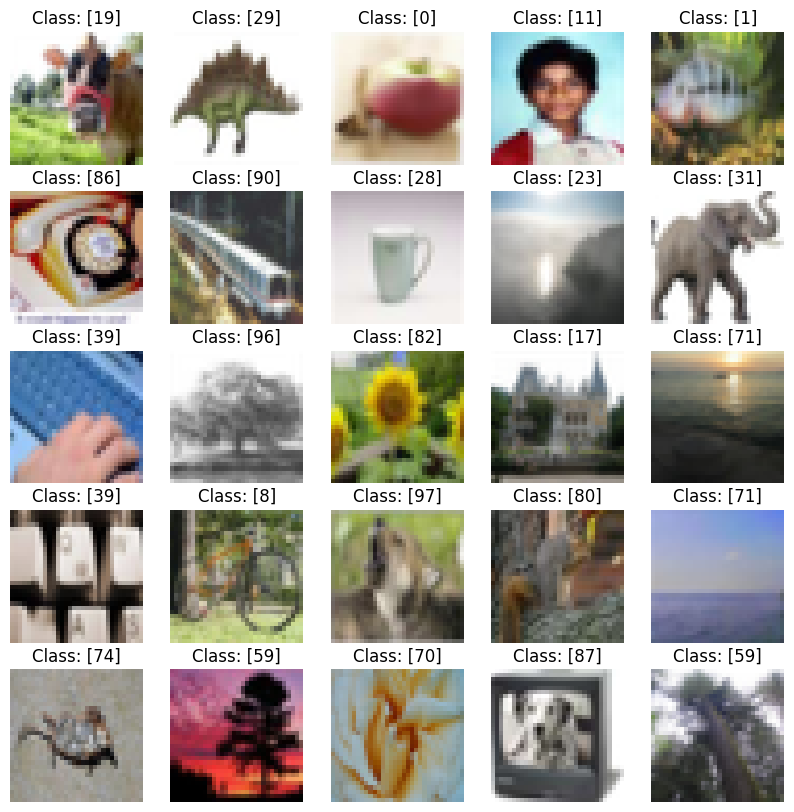

In [57]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(f'Class: {y_train[i]}')
    plt.axis('off')
plt.show()

# Printing the label of second image in training dataset and its correspoding image.

[29]


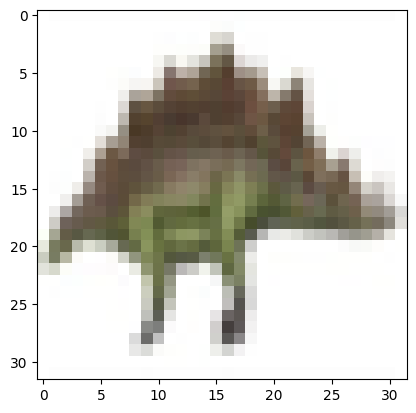

In [58]:
print(y_train[1])
plt.imshow(X_train[1])

# Data Preprocessing

In [59]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(factor=0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
    layers.RandomBrightness(factor=0.1),
    layers.RandomContrast(factor=0.1)
])

# Building the Model (CNN Architecture)

In [60]:
from tensorflow.keras import layers, models

inputs = layers.Input((32, 32, 3))

# Convolutional layers
x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

# Additional convolutional layers
x = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

# Flatten and dense layers
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(rate=0.5)(x)

# Output layer
outputs = layers.Dense(100, activation='softmax')(x)

# Create the model
model = models.Model(inputs, outputs)

# Print the model summary
model.summary()


In [61]:
# # model with Regularization

# from tensorflow.keras import layers, models, regularizers

# inputs = layers.Input((32, 32, 3))

# # Convolutional layers
# x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(inputs)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

# x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

# # Additional convolutional layers
# x = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

# # Flatten and dense layers
# x = layers.Flatten()(x)
# x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01))(x)  # Add L2 regularization
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.Dropout(rate=0.5)(x)

# # Output layer


# Custom Keras Callback for saving the Best Model

In [62]:
class GetBestModel(keras.callbacks.Callback):
    def __init__(self, monitor="val_loss", verbose=0, mode="auto"):
        super(GetBestModel, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        if self.mode == "min":
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == "min" and current < self.best:
            self.best = current
            self.best_weights = self.model.get_weights()
        elif self.mode == "max" and current > self.best:
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)

In [63]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor for learning rate reduction
    factor=0.5,  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,  # Whether to print a message when the learning rate is reduced
    min_lr=1e-6  # Lower bound on the learning rate
)

In [64]:
# best_model = GetBestModel(monitor="val_loss", mode="min", verbose=1)
# early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

#  Training of CNN with Early Stopping and Best Model Saving Callbacks

In [65]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stop, best_model])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop, best_model,learning_rate_reduction])

Epoch 1/10
1563/1563 [==============================] - 65s 40ms/step - loss: 0.8347 - accuracy: 0.7415 - val_loss: 1.8916 - val_accuracy: 0.5498 - lr: 0.0010
Epoch 2/10
1563/1563 [==============================] - 72s 46ms/step - loss: 0.7892 - accuracy: 0.7488 - val_loss: 1.9018 - val_accuracy: 0.5456 - lr: 0.0010
Epoch 3/10
1562/1563 [============================>.] - ETA: 0s - loss: 0.7506 - accuracy: 0.7615
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1563/1563 [==============================] - 73s 47ms/step - loss: 0.7505 - accuracy: 0.7615 - val_loss: 1.9133 - val_accuracy: 0.5408 - lr: 0.0010
Epoch 4/10
1563/1563 [==============================] - 73s 47ms/step - loss: 0.5520 - accuracy: 0.8225 - val_loss: 1.8597 - val_accuracy: 0.5669 - lr: 5.0000e-04
Epoch 5/10
1563/1563 [==============================] - 76s 48ms/step - loss: 0.4862 - accuracy: 0.8419 - val_loss: 1.8933 - val_accuracy: 0.5669 - lr: 5.0000e-04
Epoch 6/10
1563/1563 [============

# Building ResNet50 Model for CIFAR-100

In [66]:
# resnet = applications.ResNet50(input_shape=(32, 32, 3), include_top=False, weights=None)
# x = layers.Flatten()(resnet.output)
# x = layers.Dense(32)(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.Dropout(rate=0.5)(x)
# outputs_resnet = layers.Dense(100, activation='softmax')(x)

# model_resnet = models.Model(resnet.input, outputs_resnet)
# model_resnet.summary()

In [67]:
# best_model_resnet = GetBestModel(monitor="val_loss", mode="min", verbose=1)
# early_stop_resnet = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Training ResNet50

In [68]:
# model_resnet.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# history_resnet = model_resnet.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop_resnet, best_model_resnet])

# Building VGGNet for CIFAR-100

In [69]:
# vgg16 = applications.VGG16(input_shape=(32, 32, 3), include_top=False, weights=None)
# x = layers.Flatten()(vgg16.output)
# x = layers.Dense(128)(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.Dropout(rate=0.5)(x)
# outputs_vgg16 = layers.Dense(100, activation='softmax')(x)

# model_vgg16 = models.Model(vgg16.input, outputs_vgg16)
# model_vgg16.summary()


In [70]:
# best_model_vgg16 = GetBestModel(monitor="val_loss", mode="min", verbose=1)
# early_stop_vgg16 = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

# Trainig VGGNET for CIFAR-100

In [71]:
# model_vgg16.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# history_vgg16 = model_vgg16.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop_vgg16, best_model_vgg16])